# v3_from_t3p2_ph2.ipynb

This is a copy of  t3p2_from_rl5El.ipynb gradually adapted to control the `bouncy_planar_arm_v3` plant, following the design in `net_from_cfg.py`.

In the first phase of adaptation (`v3_from_t3p2_ph1`), we created a version without the spinal cord network. In other words no $\alpha$ motorneurons (`AL`), and no dual `CE,CI` populations for each muscle. Instead we just had 6 `C` units with the agonist-antagonist relations we had in the `net_from_cfg`.

In this second phase of adapation, each of the C units in `v3_from_t3p2_ph1` is replaced by a CE, CI, AL trio, and the connections are adjusted accordingly.

In [1]:
%cd /home/z/projects/draculab/

/home/z/projects/draculab


In [2]:
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

In [3]:
# load a configuration 
import pickle
#fname = '/home/z/projects/draculab/v3ft3p2ph1_pop_2021-05-25__10_19'
#fname = '/home/z/projects/draculab/v3ft3p2ph2_pop_2021-05-28__10_53'
fname = '/home/z/Dropbox (OIST)/saves/gene_2021-06-24'
with (open(fname, "rb")) as f:
    pop = pickle.load(f)
    f.close()

In [4]:
np.random.seed(123456) # always the same random values

cfg = pop[0]
    
t_pres = cfg['t_pres']
par_heter = cfg['par_heter']
M_size = 12 # number of units in the M population
SPF_size = 12 # number of units in the SPF population
set_C_delay = False # whether set C_cid using analytical approach
rand_targets = True # whether to train using a large number of random targets
C_noise = True # whether C units are noisy (use euler_maru integrator)
M__C_rand_w = True # whether to randomly intialize weights for the M__C connections

In [8]:
# Manipulate the configuration
if not 'C_sigma' in cfg:
    cfg['C_sigma'] = 0.3
# cfg['A__M_lrate'] = 10.
# cfg['A__M_w_sum'] = 3.
# cfg['A__M_w_max_frac'] = .5
# cfg['b_e'] = 1.
# cfg['C__C_syne'] = 1.
# cfg['C_adapt_amp'] = 4.0
# cfg['C_cid'] = 0.14
# cfg['C_slope'] = 3.
# cfg['CI__CE_w'] = -1.3
# cfg['g_e_factor'] = 2.
# cfg['M_cid'] = 0.25
# cfg['M_des_out_w_abs_sum'] = 2.
# cfg['fitness'] = None
# cfg['n_evals'] = 0
# cfg['M__C_lrate'] = 100.
# cfg['C_tau'] = 0.8
cfg['CI_slope'] = cfg['C_slope'] + .5
cfg['CI_thresh'] = cfg['C_thresh'] + .3
cfg['CI_tau'] = 0.15
cfg['g_e_03'] = 20.
cfg['II_g_03'] = 3.
cfg['M_tau'] = 0.01
cfg['SF_thresh_03'] = .4

In [5]:
cfg

{'A__M_w_max_frac': 0.2821474299061792,
 'A__M_w_sum': 1.0,
 'C_adapt_amp': 4.4,
 'C_cid': 0.14928385685463597,
 'C_sigma': 0.6235117516563925,
 'M_cid': 1.086186274505264,
 'M_des_out_w_abs_sum': 3.107279886064089,
 'g_e_factor': 3.0,
 'C_slope': 2.2011316990818015,
 'C_thresh': 1.2149845292791328,
 'C_tau': 0.27053136551533774,
 'C_tau_slow': 21.0,
 'A__M_lrate': 19.21107551330622,
 'AL_thresh': 0.55,
 'b_e': 1.0,
 'C__C_antag': 1.5,
 'C__C_p_antag': 0.25,
 'C__C_p_syne': 0.3,
 'C__C_syne': 1.0,
 'CE__CI_w': 0.5,
 'CI__CE_w': -1.3,
 'M__C_lrate': 300.0,
 'M__C_w_sum': 2.3,
 'M__M_w': -0.5,
 'SPF__SPF_w': -1.5,
 'fitness': 0.03948702571867947,
 'n_evals': 1,
 't_pres': 40,
 'par_heter': 0.01,
 'g_e_03': 20.32763342859054,
 'CI_slope': 4.158365408276022,
 'CI_tau': 0.09203223283805521,
 'CI_thresh': 1.1732843581279722,
 'II_g_03': 3.0,
 'M_tau': 0.01,
 'SF_thresh_03': 0.4}

In [6]:
# Create the network with the net_from_cfg function
%cd /home/z/projects/draculab/notebook/spinal/
from v3ft3p2ph2_net import *
%cd ../..

net, pops_dict, hand_coords, m_idxs = net_from_cfg(cfg,
                                                   t_pres = t_pres,
                                                   par_heter = par_heter,
                                                   set_C_delay = set_C_delay,
                                                   rand_targets = rand_targets,
                                                   track_weights = True,
                                                   track_ips = True,
                                                   C_noise = C_noise,
                                                   M__C_rand_w = M__C_rand_w)

# net, pops_dict, hand_coords, m_idxs = syne_net(cfg,
#                                                t_pres = t_pres,
#                                                par_heter = par_heter,
#                                                set_C_delay = set_C_delay,
#                                                rand_targets = rand_targets,
#                                                track_weights = True,
#                                                track_ips = True,
#                                                C_noise = C_noise,
#                                                M__C_rand_w = M__C_rand_w)

for name in pops_dict:
    exec("%s = %s"% (name, str(pops_dict[name])))

/home/z/projects/draculab/notebook/spinal
/home/z/projects/draculab


In [7]:
# Some hacks to run jPCA analysis with networks from net_from_cfg
# The risk is that at some point these may no longer correspond to
# what's used in net_from_cfg
P__A_syn = {'type' : synapse_types.static,
            'init_w' : None }
P__A_syn['init_w'] = [syn_list[0].w for syn_list in [net.syns[a] for a in A]]
P__A_ws = np.array(P__A_syn['init_w'][12:18])
A__SF_syn = {'type' : synapse_types.static,
             'init_w' : [1.]*6 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : np.array([cfg['SF_thresh_03'], 0.4, 0.4, cfg['SF_thresh_03'], 0.4, 0.4]),
             'slope' : np.array([4.]*6),
             'init_val' : 0.2,
             'tau' : 0.02 }

In [7]:
## Create the network directly

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Parameter dictionaries for the network and the plant
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 8 }
# plant parameters
P_params = {'type' : plant_models.bouncy_planar_arm_v3,
          'mass1': 1.,
          'mass2': 1.,
          's_min' : -0.8,
          'p1' : (-0.01, 0.04),
          'p2' : (0.29, 0.03),
          'p3' : (0., 0.05),
          'p5' : (0.01, -0.05),
          'p10': (0.29, 0.03),
          'init_q1': 0.,
          'init_q2': np.pi/2.,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 3.,
          'mu2': 3.,
          'l_torque' : 0.01,
          'l_visco' : 0.01,
          'g_e' : cfg['g_e_factor']*np.array([cfg['g_e_03'], 20., 20.,
                                              cfg['g_e_03'], 22., 23.]),
          'l0_e' : [1.]*6,
          'Ia_gain' : 2.5*np.array([3.,10.,10.,3.,10.,10.]),
          'II_gain' : 2.*np.array([cfg['II_g_03'], 8., 8.,
                                   cfg['II_g_03'], 8., 8.]),
          'Ib_gain' : 1.,
          'T_0' : 10.,
          'k_pe_e' : 20.,  #8
          'k_se_e' : 20., #13
          'b_e' : cfg['b_e'],
          'g_s' : 0.02,
          'k_pe_s' : 2., 
          'k_se_s' : 2.,
          'g_d' : 0.01,
          'k_pe_d' : .2, #.1,
          'k_se_d' : 1., #2.,
          'b_s' : .5,
          'b_d' : 2.,#3.,
          'l0_s': .7,
          'l0_d': .8,
          'fs' : 0.1,
          'se_II' : 0.5,
          'cd' : 0.5,
          'cs' : 0.5,
          'tau' : 0.1   # ficticious time constant used in create_freqs_steps
           }
#--------------------------------------------------------------------
# Unit parameters
#--------------------------------------------------------------------
randz = lambda n: (1. + par_heter*(np.random.rand(n)-0.5))

A_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.01, # 0.02
            'tau_fast': 0.005,
            'thresh' : np.array([.2]*6 + [0.]*6 + [.2]*6) } # [Ib, Ia, II]
ACT_params = {'type' : unit_types.act,
              'tau_u' : 10., #6., #8
              'gamma' : 8., #6., #2
              'g' : 2.,
              'theta' : 1.5, #1.,
              'tau_slow' : 5.,
              'y_min' : 0.1, #0.2
              'rst_thr' : 0.1,
              'init_val' : 0. }
spf_sum_min = 1. # .6 # value where no corrections are needed anymore
y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
ACT_params['y_min'] = y_min

AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : cfg['AL_thresh'] * randz(6),
             'slope' : 2. * randz(6),
             'init_val' : 0.1 * randz(6),
             'tau' : 0.02 * randz(6) }
CE_params = {'type' : unit_types.rga_adapt_sig,
            'integ_meth' : 'euler_maru' if C_noise else 'odeint',
            'init_val' : [r*np.array([0.5]) for r in np.random.random(6)],
            'multidim' : False,
            'slope' : cfg['C_slope'],
            'thresh' : cfg['C_thresh'],
            'tau' : cfg['C_tau'],
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : cfg['C_tau_slow'],
            'custom_inp_del' : int(round(cfg['C_cid']/net_params['min_delay'])),
            'delay' : 0.31, # to be set below
            'adapt_amp' : cfg['C_adapt_amp'],
            'mu' : 0.,
            'sigma' : cfg['C_sigma'] }
CI_params = {'type' : unit_types.rga_adapt_sig,
            'integ_meth' : 'euler_maru' if C_noise else 'odeint',
            'init_val' : [r*np.array([0.5]) for r in np.random.random(6)],
            'multidim' : False,
            'slope' : cfg['CI_slope'] if 'CI_slope' in cfg else cfg['C_slope'],
            'thresh' : cfg['CI_thresh'] if 'CI_thresh' in cfg else cfg['C_thresh'], 
            'tau' : cfg['CI_tau'] if 'CI_tau' in cfg else cfg['C_tau'],
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : cfg['C_tau_slow'],
            'custom_inp_del' : int(round(cfg['C_cid']/net_params['min_delay'])),
            'delay' : 0.31, # to be set below
            'adapt_amp' : cfg['C_adapt_amp'],
            'mu' : 0.,
            'sigma' : cfg['C_sigma'] }
M_params = {'type' : unit_types.m_sig,
            'thresh' : 0.5 * randz(M_size) + cfg['A__M_w_sum'] / 2.,
            'slope' : 2.5 * randz(M_size),
            'init_val' : 0.2 * randz(M_size),
            'delay' : 0.35, # to be set below
            'n_ports' : 4,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 8.,
            'tau' : cfg['M_tau'] * randz(M_size),
            'integ_amp' : 0.,
            'custom_inp_del' : int(np.round(cfg['M_cid']/net_params['min_delay'])) ,
            'des_out_w_abs_sum' : cfg['M_des_out_w_abs_sum'] }
# SF, SP
SFth = cfg['SF_thresh_03']
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : np.array([SFth, 0.4, 0.4, SFth, 0.4, 0.4]),
             'slope' : np.array([4.]*6),
             'init_val' : 0.2,
             'tau' : 0.02 }  # 0.05
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.01,
             'tau_mid' : 0.2,
             'function' : lambda t: None }
SP_CHG_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.25,
              'slope' : 9.,
              'init_val' : 0.1,
              'tau' : 0.01 }
# 1-D error units
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.1 * randz(SPF_size),
              'slope' : 9. * randz(SPF_size),
              'init_val' : 0.3 * randz(SPF_size),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz(SPF_size) }      
# units to track synaptic weights or other values
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#--------------------------------------------------------------------
# Connection dictionaries
#--------------------------------------------------------------------
# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

antagonists += [(p[1],p[0]) for p in antagonists]
part_antag += [(p[1],p[0]) for p in part_antag]
synergists += [(p[1],p[0]) for p in synergists]
part_syne += [(p[1],p[0]) for p in part_syne]
all_pairs = [(i,j) for i in range(6) for j in range(6)]

# Afferent to motor error selection
A__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
A__M_syn = {'type' : synapse_types.inp_sel, 
            'inp_ports' : 2, # the default for m_sig targets
            'error_port' : 1, # the default for m_sig targets
            'aff_port' : 2,
            'lrate' : cfg['A__M_lrate'], # negative rate for m_sig targets with value inputs
            'w_sum' : cfg['A__M_w_sum'],
            'w_max' : cfg['A__M_w_max_frac']*cfg['A__M_w_sum'],
            'init_w' : .1 }
A__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
A__SF_syn = {'type' : synapse_types.static,
             'init_w' : [1.]*6 }
# ACT to C ------------------------------------------------
ACT__C_conn = {'rule' : "all_to_all",
               'delay' : 0.02 } 
ACT__C_syn = {'type' : synapse_types.static,
              'inp_ports' : 2,
              'init_w' : 1. }
# CE, CI to AL ----------------------------------------------
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : 1. }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# CE,CI to CE,CI within the same population -----------------
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'init_w' : cfg['CE__CI_w'] }
CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
              'inp_ports' : 1,
              'lrate' : .0,
              'des_act' : 0.5,
              'init_w' : cfg['CI__CE_w'] }
# synergist and antagonist connections in C
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.01 }
C__C_syn_antag = {'type' : synapse_types.static,
                  'inp_ports': 1, # "lateral" port of rga_21 synapses
                  'init_w' : cfg['C__C_antag'] }
C__C_syn_p_antag = {'type' : synapse_types.static,
                    'inp_ports': 1,
                    'init_w' : cfg['C__C_p_antag'] }
C__C_syn_syne = {'type' : synapse_types.static,
                  'inp_ports': 1,
                  'init_w' : cfg['C__C_syne'] }
C__C_syn_p_syne = {'type' : synapse_types.static,
                  'inp_ports': 1,
                  'init_w' : cfg['C__C_p_syne']}
C__C_syn_null_lat = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 1,
                   'init_w' : 0. }
# spinal units to plant
AL__P_conn = {'inp_ports' : list(range(6)),
             'delays': 0.02 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# motor to spinal
if not M__C_rand_w:
    # initializing M__C weights manually
    M_CE = np.array(
        [[ 1., .3, 0.,-.5, .3, 0.],
         [ .3, 1.,-.5, 0., 0., 0.],
         [ 0.,-.5, 1., .3, 0., 0.],
         [-.5, 0., .3, 1., 0., .3],
         [ .3, 0., 0., 0., 1.,-.5],
         [ 0., 0., 0., .3,-.5, 1.]])
    M_CE = M_CE.flatten('C')
    M_CE = np.concatenate((M_CE, -M_CE))
    M_CI = -M_CE
    M__CE_iw = M_CE
    M__CI_iw = M_CI
else:
    M__CE_iw = {'distribution':'uniform', 'low':0.05, 'high':.1}
    M__CI_iw = {'distribution':'uniform', 'low':0.05, 'high':.1}
    
M__C_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : synapse_types.rga_21,
             'lrate': cfg['M__C_lrate'],
             'inp_ports': 0,
             'w_sum' : cfg['M__C_w_sum'],
             'init_w' : M__CE_iw}
M__CI_syn = {'type' : synapse_types.rga_21,
             'lrate': cfg['M__C_lrate'],
             'inp_ports': 0,
             'w_sum' : cfg['M__C_w_sum'],
             'init_w' : M__CI_iw}
# motor error lateral connections
M__M_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.02 } # the delay assumes an intermediate interneuron
M__M_syn = {'type' : synapse_types.static,
            'inp_ports': 3, # default for m_sig targets
            'init_w' : cfg['M__M_w'] }
# plant to afferent
idx_aff = np.arange(22,40) # indexes for afferent output in the arm
P__A_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
P__A_syn = {'type' : synapse_types.static,
            'init_w' : [2.]*6 + [2.]*6 + [4.]*6 } # weights for [Ib, Ia, II]
# SF/SP to SPF
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP to SP_CHG ------------------------------------------------
SP__SP_CHG_conn = {'rule' : 'all_to_all',
                    'delay' : 0.01}
SP__SP_CHG_syn = {'type' : synapse_types.chg,
                  'init_w' : 0.,
                  'lrate' : 20. }
# SP_CHG to ACT ------------------------------------------------
SP_CHG__ACT_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__ACT_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : 1. }
# SPF to ACT ------------------------------------------------
SPF__ACT_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
SPF__ACT_syn = {'type' : synapse_types.static,
                'inp_ports' : 0,
                'init_w' : 1. }
# SPF to M
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.02 }
SPF__M_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'init_w' : 1. }
# sensory error lateral connections
SPF__SPF_conn = {'rule': 'one_to_one',
                 'allow_autapses' : False,
                 'delay' : 0.02 } # the delay assumes an intermediate interneuron
SPF__SPF_syn = {'type' : synapse_types.static,
                'inp_ports': 0,
                'init_w' : cfg['SPF__SPF_w'] }
# utility function to set C_params['custom_inp_del']
def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.

        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-A-M-C.

        Args:
            f : main oscillation frequency of in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    a_del = np.arctan(np.mean(A_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__A_conn['delays']),
         A__M_conn['delay'], M__C_conn['delay'] ]
    time_del = al_del + p_del + a_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps

if set_C_delay is True:
    C_time_del, C_del_steps = approx_del(1.)
    CE_params['custom_inp_del'] = C_del_steps
    CI_params['custom_inp_del'] = C_del_steps

CE_params['delay'] = (CE_params['custom_inp_del'] + 2) * net_params['min_delay']
CI_params['delay'] = (CI_params['custom_inp_del'] + 2) * net_params['min_delay']
M_params['delay'] = max(CE_params['delay'], CI_params['delay'],
                    (M_params['custom_inp_del'] + 2) * net_params['min_delay'])

#--------------------------------------------------------------------
# CREATING NETWORK AND UNITS
#--------------------------------------------------------------------
net = network(net_params)

A = net.create(18, A_params)
AL = net.create(6, AL_params)
ACT = net.create(1, ACT_params)
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
M = net.create(12, M_params)
P = net.create(1, P_params)
SF = net.create(6, SF_params)
SP = net.create(6, SP_params)
SP_CHG = net.create(1, SP_CHG_params)
SPF = net.create(12, SPF_params)

# tracking units
M_CE0_track = net.create(M_size, track_params) # to track weights from M to C0
A_M0_track = net.create(12, track_params) # to track weights from A to M0
ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--
# SET THE PATTERNS IN SP -----------------------------------------------------
# list with hand coordinates [x,y] (meters)
if rand_targets is False:
    hand_coords = [[0.3, 0.45], 
                   [0.35, 0.4],
                   [0.4, 0.35],
                   [0.35, 0.3],
                   [0.3, 0.25],
                   [0.25, 0.3],
                   [0.2, 0.35],
                   [0.25, 0.4]]
else:
    # creating a list of random coordinates to use as targets
    min_s_ang = -0.1 # minimum shoulder angle
    max_s_ang = 0.8  # maximum shoulder angle
    min_e_ang = 0.2 # minimum elbow angle
    max_e_ang = 2.3 # maximum elbow angle
    n_coords = 1000 # number of coordinates to generate
    l_arm = net.plants[P].l_arm # upper arm length
    l_farm = net.plants[P].l_farm # forearm length
    hand_coords = [[0.,0.] for _ in range(n_coords)]
    s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
    e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
    for i in range(n_coords):
        hand_coords[i][0] = l_arm*np.cos(s_angs[i]) + l_farm*np.cos(s_angs[i]+e_angs[i]) # x-coordinate
        hand_coords[i][1] = l_arm*np.sin(s_angs[i]) + l_farm*np.sin(s_angs[i]+e_angs[i]) # y-coordinate

# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(net.plants[P].coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
#Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
#Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
#Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the afferent units
P__A_ws = np.array(P__A_syn['init_w'][12:18])
#Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
A_thr = np.array([net.units[u].thresh for u in A[12:18]])
A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from A to SF
SF_arg = A__SF_syn['init_w']*A_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP
m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
    #m_idxs[0] = 0 # for testing
A_us = [net.units[u] for u in A]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor(t/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        A__SF_syn['init_w'][idx] * (
                        np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                        net.units[A[12+idx]].thresh, 0.))))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))
#--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--

#--------------------------------------------------------------------
# CONNECTING
#--------------------------------------------------------------------
# From afferent units
net.connect(A[:12], M, A__M_conn, A__M_syn)
net.connect(A[12:18], SF, A__SF_conn, A__SF_syn)
# From ACT
net.connect(ACT, CE, ACT__C_conn, ACT__C_syn)
net.connect(ACT, CI
            , ACT__C_conn, ACT__C_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# intraspinal connections
for pair in all_pairs:
    if pair in synergists:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_syne)
        #net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_syne:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_p_syne)
        #net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in antagonists:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_antag)
        #net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_antag:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_p_antag)
        #net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in self_conn:
        net.connect([CE[pair[0]]], [CI[pair[1]]], CE__CI_conn, CE__CI_syn)
        net.connect([CI[pair[0]]], [CE[pair[1]]], CI__CE_conn, CI__CE_syn)
#     else:
#         net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
#         net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
#         net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
#         net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
# From M 
net.connect(M, CE, M__C_conn, M__CE_syn)
net.connect(M, CI, M__C_conn, M__CI_syn)
net.connect(M, M, M__M_conn, M__M_syn)
# From plant to afferents
net.set_plant_outputs(P, A, P__A_conn, P__A_syn) 
# From SF, SP to SPF
net.connect(SF, SPF[:6], SFe__SPF_conn, SFe__SPF_syn)
net.connect(SF, SPF[6:12], SFi__SPF_conn, SFi__SPF_syn)
net.connect(SP, SPF[:6], SPi__SPF_conn, SPi__SPF_syn)
net.connect(SP, SPF[6:12], SPe__SPF_conn, SPe__SPF_syn)
# from SP to SP_CHG
net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
# from SP_CHG to ACT
net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
# From SPF
net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
net.connect(SPF, M, SPF__M_conn, SPF__M_syn)
net.connect(SPF, SPF, SPF__SPF_conn, SPF__SPF_syn)

# SETTING UP WEIGHT TRACKING
def M_CE0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[CE[0]][idx].w
base = 0
for idx in range(len(M)):
    rga_syn = False
    while not rga_syn:
        if net.syns[CE[0]][base+idx].type in [synapse_types.rga_21]:
            rga_syn = True
        else:
            base += 1
            if base > 100:
                raise AssertionError('Could not create M_CE tracker unit')
    net.units[M_CE0_track[idx]].set_function(M_CE0_fun(base+idx))

def A_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
base = 0
for idx, uid in enumerate(A_M0_track):
    rga_syn = False
    while not rga_syn:
        if net.syns[M[0]][base+idx].type in [synapse_types.inp_sel]:
            rga_syn = True
        else:
            base += 1
            if base > 100:
                raise AssertionError('Could not create A_M tracker unit')
    net.units[uid].set_function(A_M0_fun(base+idx))


# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [8]:
# Run simulation
sim_time = 600.
start_time = time.time()
times, data, plant_data  = net.flat_run(sim_time)

data = np.array(data)
print('Execution time is %s seconds' % (time.time() - start_time))

Execution time is 1483.5663433074951 seconds


In [13]:
# remove noise from C units
for u in [net.units[c] for c in CE+CI]:
    u.sigma = 0
    
# increase the muscle gains
for idx in range(6):
    net.plants[0].inp_syns[idx][0].w = 1.5

In [14]:
# Run simulation
sim_time = 320.
start_time = time.time()
times, data, plant_data  = net.flat_run(sim_time)

data = np.array(data)
print('Execution time is %s seconds' % (time.time() - start_time))

Execution time is 781.0025508403778 seconds


In [22]:
arm_activs = plant_data[P]
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE0_track])
plt.plot(times, w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--C0' for i in range(len(M_CE0_track))]
plt.legend(M_CE0_legends)
plt.title('M--C0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track[0:18]])
plt.plot(times, w_track_data2.transpose())
A_M0_legends = ['A'+str(i)+'--M0' for i in range(len(A_M0_track[:12]))]
plt.legend(A_M0_legends)
plt.title('A--M0 weights exc')
"""
W_fig3 = plt.figure(figsize=fs)
w_track_data3 = np.array(data[AF_M0_track[18:]])
plt.plot(times, w_track_data3.transpose())
AF_M0_legends2 = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track[18:]))]
plt.legend(AF_M0_legends2)
plt.title('AF--M0 weights inh')
"""

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[0.26435798 0.25524377 0.38985006 0.32794859 0.23753712 0.34432724
 0.31665277 0.32446318 0.204958   0.25411603 0.34554665 0.23983573]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[0.21287313 0.20263511 0.30334687 0.28854987 0.21127458 0.2911423
 0.28686542 0.26807259 0.18317839 0.20501036 0.29001704 0.20990834]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

shoulder angle: -0.179558, shoulder vel: 1.547154
A_data:
[0.33270689 0.36903758 0.09845221 0.16342544 0.26579655 0.33245073
 0.19990713 0.25662132 0.1411639  0.16860394 0.19787751 0.19196642
 0.6801275  0.73217741 0.34197179 0.57877313 0.52509746 0.55632524]


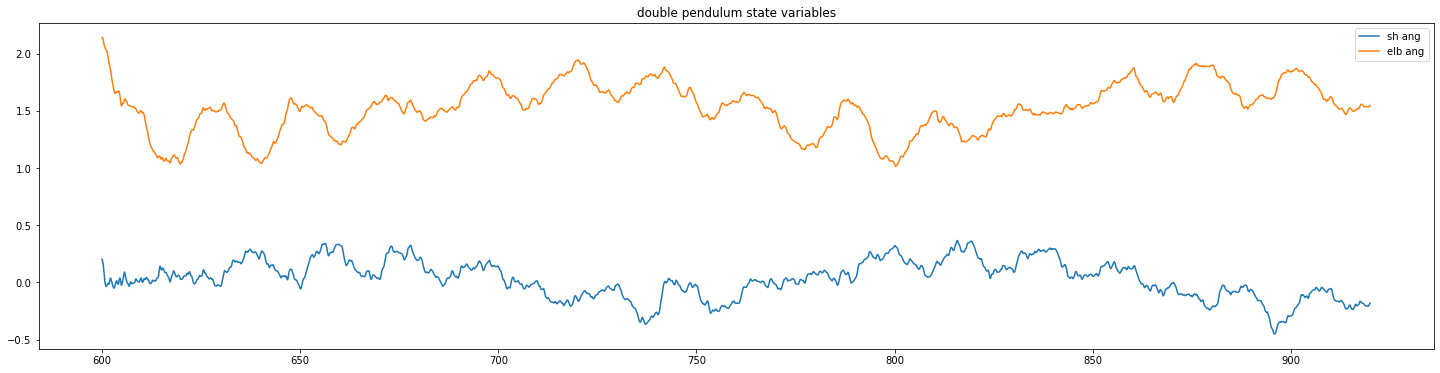

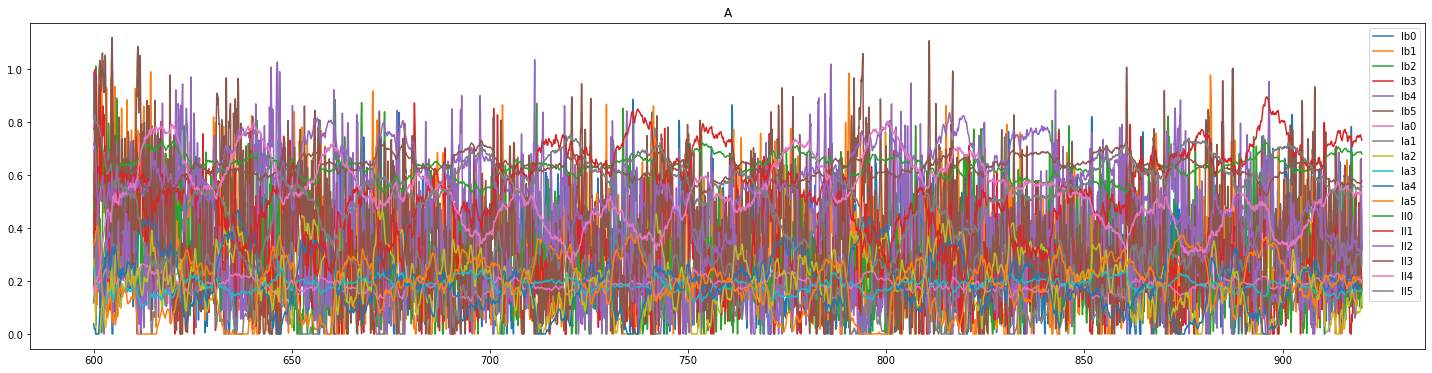

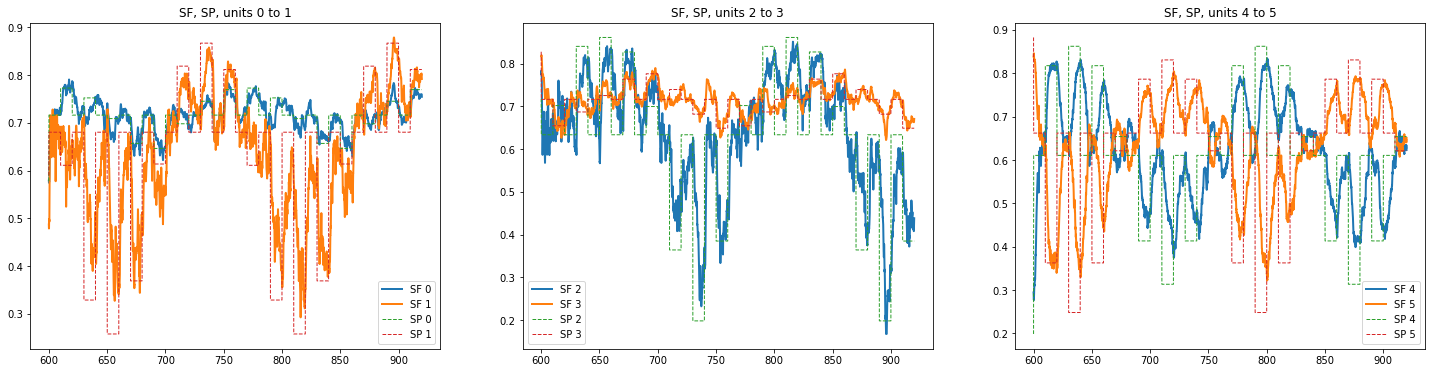

SF = 
[0.75475823 0.79212515 0.43848768 0.67058596 0.623077   0.65094615]
SP = 
[0.76973097 0.81191435 0.38516354 0.64890924 0.65398487 0.62112709]


In [16]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A[0:18]])
plt.plot(times, A_data.transpose())
A_legends = ['Ib' + str(i) for i in range(6)] + \
            ['Ia' + str(i) for i in range(6)] + \
            ['II' + str(i) for i in range(6)]
plt.legend(A_legends)
plt.title('A')
print('A_data:')
print(A_data[:,-1])

#fs = (30,6)
# SF, SP
SF_fig, axs = plt.subplots(1, 3, figsize=(fs[0], fs[1]))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
if 'lowpass_SP' in locals() and lowpass_SP is True:
    LPF_SP_data = np.array(data[LPF_SP])
for col in range(3):
    ax = axs[col]
    base = 2*col
    ax.plot(times, SF_data[base:base+2, :].transpose(), linewidth=2)
    ax.plot(times, SP_data[base:base+2, :].transpose(), '--', linewidth=1)
    if 'lowpass_SP' in locals() and lowpass_SP is True:
        ax.plot(times, LPF_SP_data[base:base+2, :].transpose(), linewidth=2)
    ax.set_title('SF, SP, units %d to %d' % (base, base+1))
    SF_legends = ['SF '+ str(base+i) for i in range(2)]
    SP_legends = ['SP '+ str(base+i) for i in range(2)]
    ax.legend(SF_legends + SP_legends)

plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

average error: 0.046850


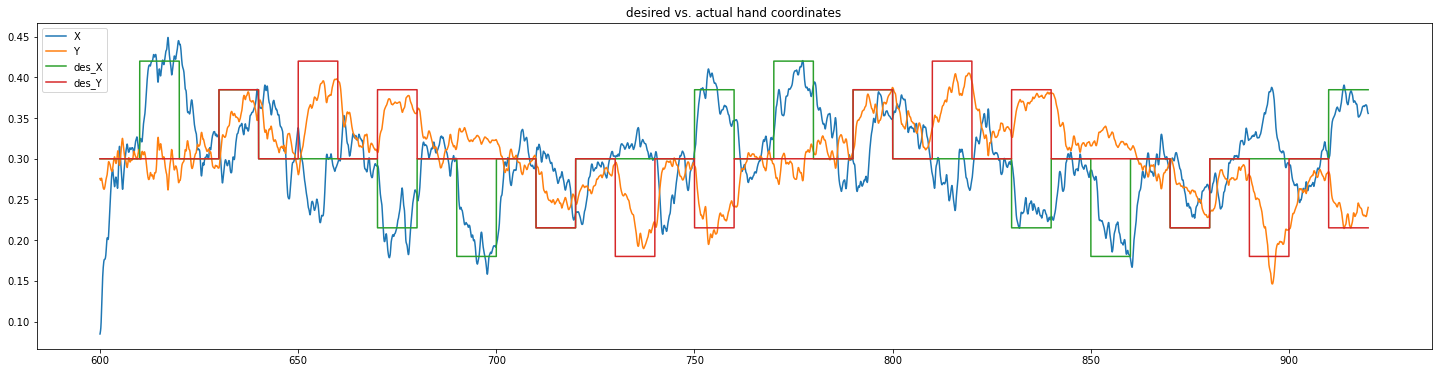

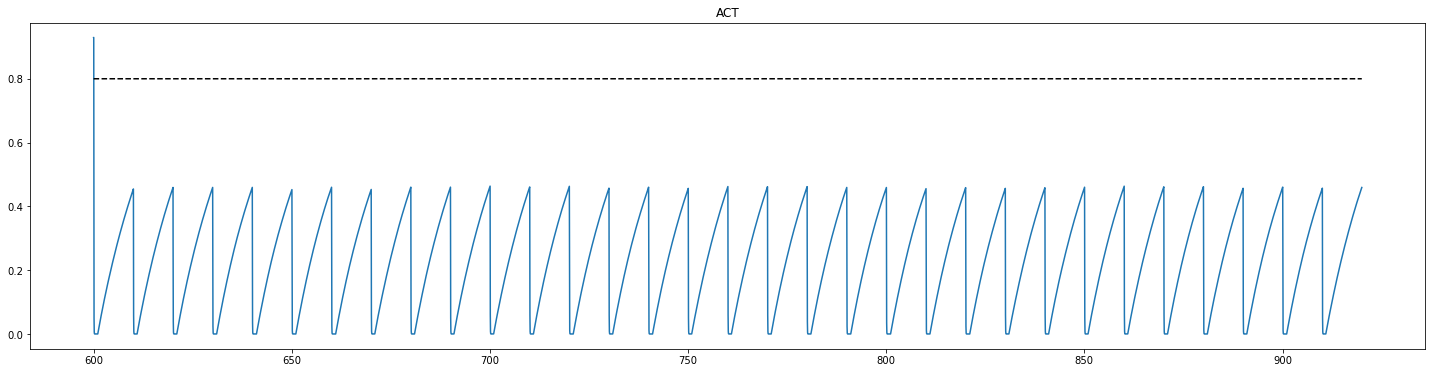

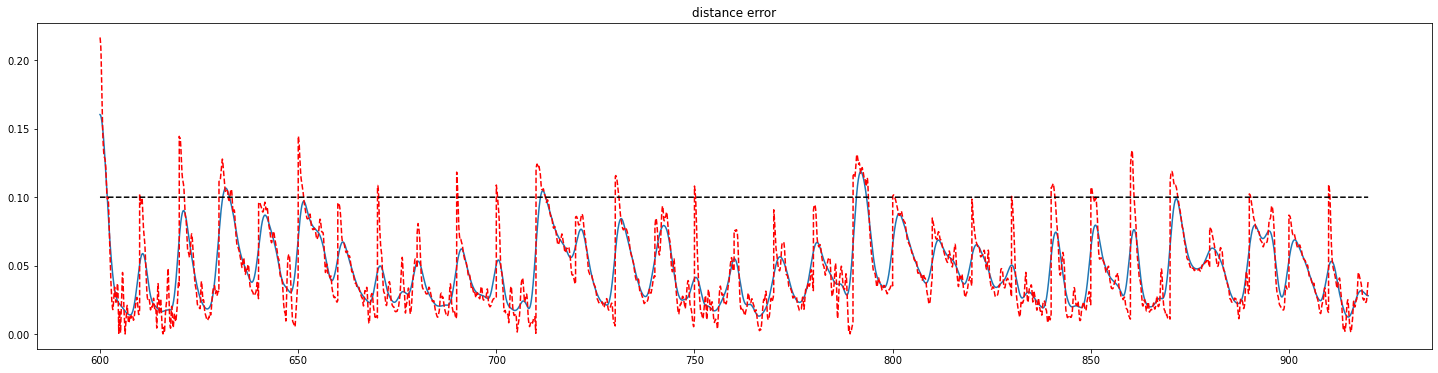

In [17]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times-start_t)/t_pres).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times/t_pres).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)
plt.plot(times, des_coords)
plt.title('desired vs. actual hand coordinates')
plt.legend(['X', 'Y', 'des_X', 'des_Y'])

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('ACT')

err_fig = plt.figure(figsize=fs)
w_len = 1001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times, smooth_hand_error)
plt.plot(times, hand_error, 'r--')
plt.plot(times, 0.1+np.zeros(smooth_hand_error.size), 'k--')
plt.title('distance error')
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))

plt.show()

In [26]:
from spectrum import Periodogram
fig = plt.figure()
spec_data = data[M[0]][0:2048]
p = Periodogram(spec_data, sampling=(1./net.min_delay))
p()
p.plot(marker='o')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AL_data:
[0.09610887 0.07525853 0.06240601 0.06305812 0.06837748 0.14504181]
Ib avg for muscle 0= 0.2719003632630074
Ia avg for muscle 0= 0.10194696773162426
II avg for muscle 0= 0.2705069035524904
Ib avg for muscle 1= 0.29122130445088373
Ia avg for muscle 1= 0.11138911257371946
II avg for muscle 1= 0.2378428279426461
Ib avg for muscle 2= 0.2835701169731426
Ia avg for muscle 2= 0.11190619456758455
II avg for muscle 2= 0.23915542538115087
Ib avg for muscle 3= 0.2775662174925734
Ia avg for muscle 3= 0.10069726945547838
II avg for muscle 3= 0.2701462465864167
Ib avg for muscle 4= 0.31775463427880446
Ia avg for muscle 4= 0.10903763421229093
II avg for muscle 4= 0.22854260615294317
Ib avg for muscle 5= 0.3313492370554238
Ia avg for muscle 5= 0.10646193045942617
II avg for muscle 5= 0.23113639051326473


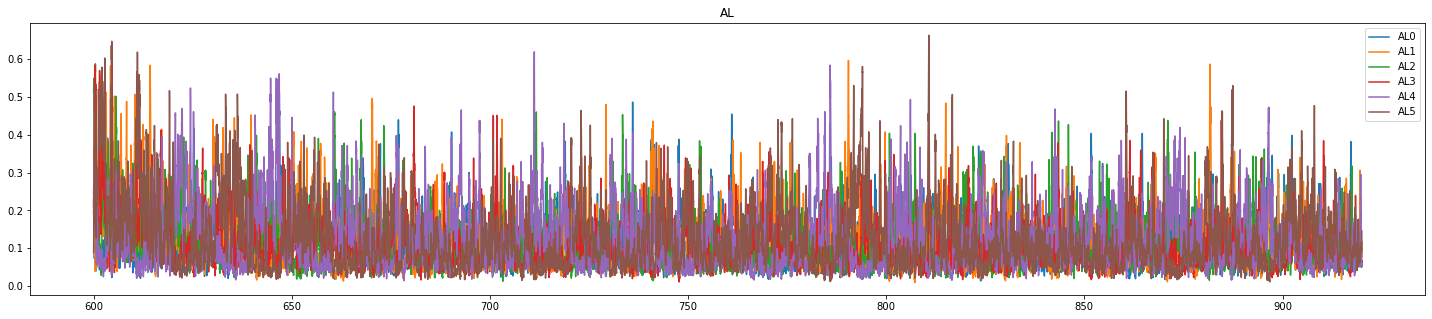

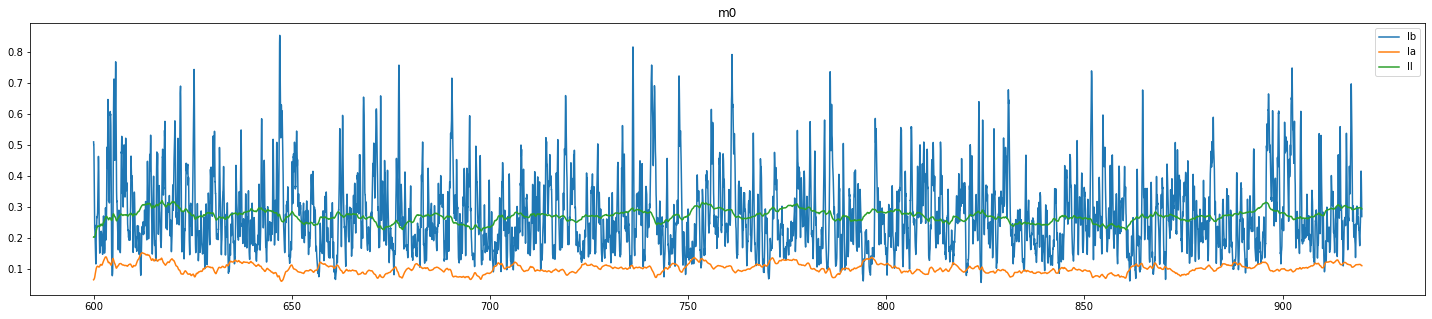

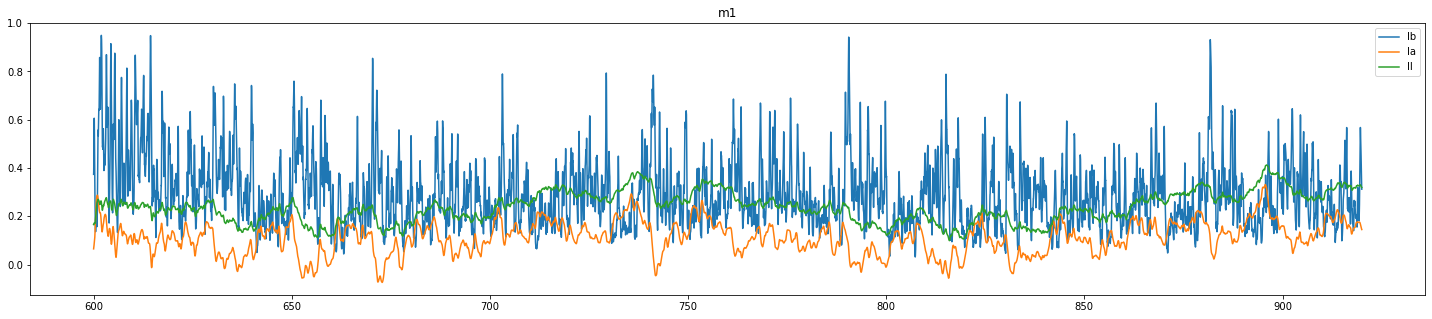

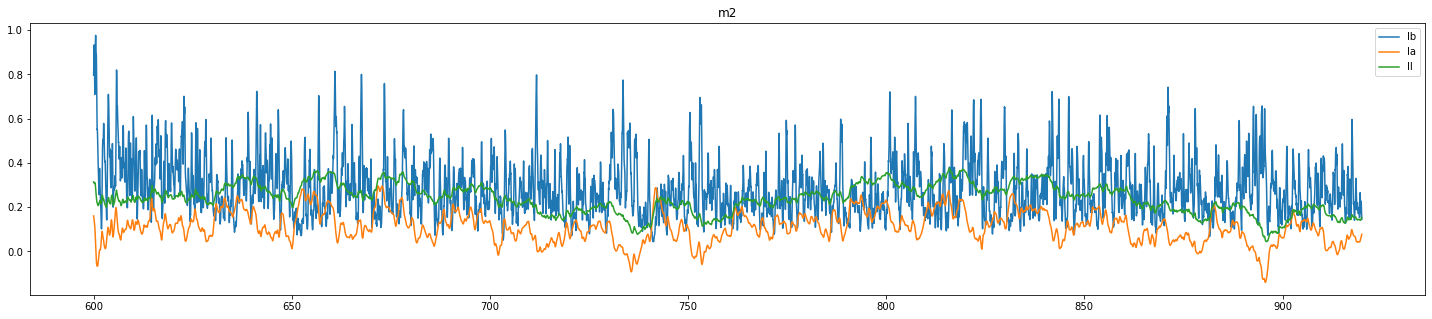

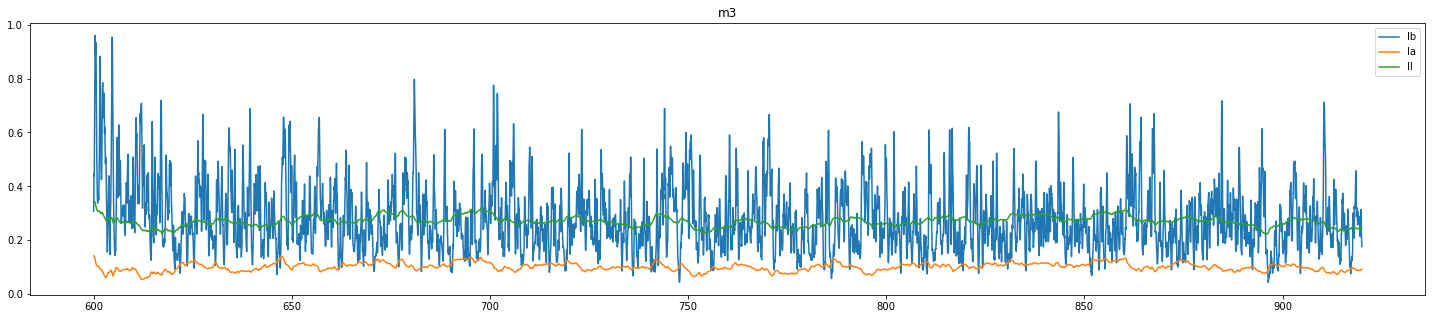

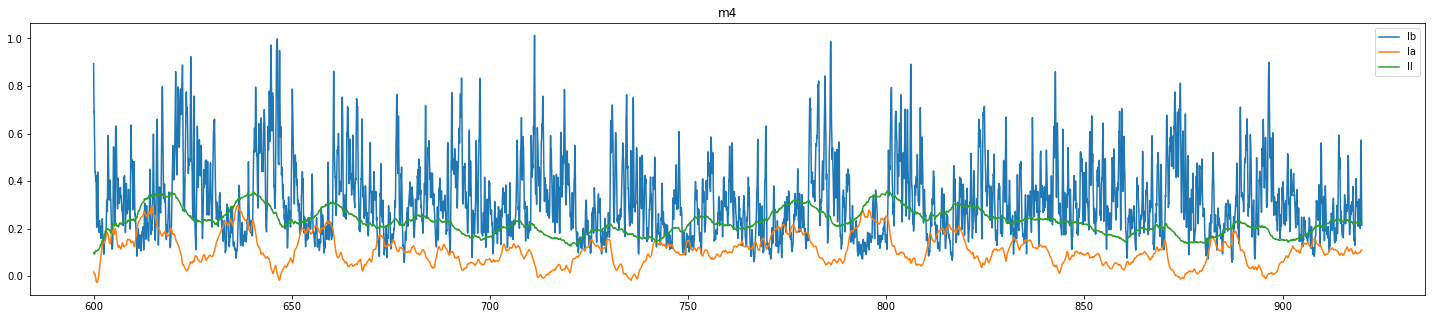

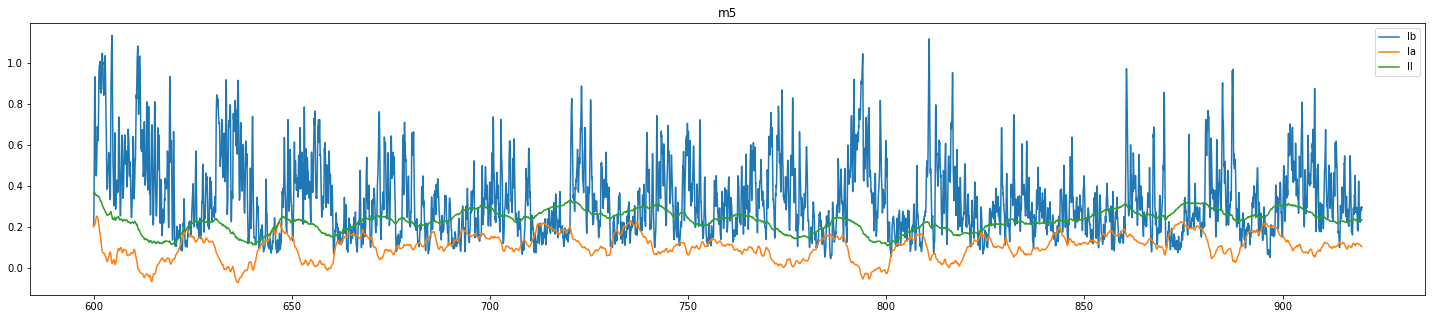

In [18]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
fs2 =(25,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

In [13]:
# set new targets
arm = net.plants[P]
t_pres = 10. # new presentation time
start_t = net.sim_time # starting time for new simulation
# 8 radial targets in sequence, from 0 to 315 degrees
r = 0.12 # distance from center to targets
center = np.array([0.3, 0.3]) # initial hand location
n_trgs = 8 # number of targets
angs = np.linspace(0., 2.*np.pi, n_trgs+1)[:-1]
circle = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
targets = center + r*circle # coordinates of the targets
hand_coords = [center, targets[0],
               center, targets[1],
               center, targets[2],
               center, targets[3],
               center, targets[4],
               center, targets[5],
               center, targets[6],
               center, targets[7]]

hand_coords = 50*hand_coords # many repetitions of the same sequence
#hand_coords = 10*[targets[i] for i in np.random.permutation(len(targets))]
#### next is a copy-pasta of the code to set the SP values
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
#Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
#Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
#Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the afferent units
P__A_ws = np.array(P__A_syn['init_w'][12:18])
#Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
A_thr = np.array([net.units[u].thresh for u in A[12:18]])
A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from A to SF
SF_arg = A__SF_syn['init_w']*A_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP
#m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
m_idxs = list(range(len(hand_coords))) # reach list targets sequentially
    #m_idxs[0] = 0 # for testing
A_us = [net.units[u] for u in A]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor((t-start_t)/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        A__SF_syn['init_w'][idx] * (
                        np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                        net.units[A[12+idx]].thresh, 0.))))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

The following code will obtain mean firing rates corresponding to each of the 8 directions.
To do this, from the onset of a reach, until the velocity begins to decrease, a mean rate is obtained for each of the units in M.

The protocol is to first run a normal simulation until the arm is doing reaches with oscillations, ~600 seconds. Then new targets are set with the cell above, and the simulation is continued so that every target is attempted twice (which requires 32*t_pres seconds of simulated time). The mean rates are obtained from the second set of reaches.

If the initial training simulation lasts 600 seconds, and t_pres=20, the time when the reach to the first target begins (`fr_time` below) is 600 + 16*20 + 20 = 940

In [ ]:
# We measure velocities for each reach.
# We define the velocity at times[i] to be the norm of the vector from the hand position at 
# times[i] to the hand position at times[i+idely], divided by (times[i+idely]-times[i]).
idely = 20 # a difference of 0.1 seconds if min_delay=0.005
# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = np.cos(theta_s)*l1
ye = np.sin(theta_s)*l1
xh = xe + np.cos(phi)*l2
yh = ye + np.sin(phi)*l2
# obtaining difference vector
dv_x = xh[idely:] - xh[:-idely]
dv_y = yh[idely:] - yh[:-idely]
diff_vec = np.concatenate((dv_x.reshape(1,dv_x.size), dv_y.reshape(1,dv_y.size)), axis=0)
# obtaining the velocity vector
vels = np.linalg.norm(diff_vec, axis=0) / (times[idely:]-times[:-idely])
vels = np.concatenate((vels, np.zeros(idely))) # so it keeps the same length
dv_x = np.concatenate((dv_x, np.zeros(idely)))
dv_y = np.concatenate((dv_y, np.zeros(idely)))

In [ ]:
# Obtaining mean M activities from reach initiation to peak velocity
# Assuming that simulation started with a reach to central position, then 
# reaches alternated center-target-center-target every t_pres seconds.
if 'targets' in locals():
    n_trgs = len(targets) # number of targets
else:
    raise AssertionError('No targets array found!')
#---------------------------------------------------------------------------
## obtaining peak velocity times (when acceleration first becomes negative)
#---------------------------------------------------------------------------
vels_diff = vels[idely:] - vels[:-idely]
vels_diff = np.concatenate((np.zeros(idely), vels_diff)) # so it keeps the same length
# segmenting the vectors into reaches to individual peripheral targets
pr_len = int(np.round(t_pres/net.min_delay)) # number of vector entries per presentation
vels_pr = [vels[(2*trg+1)*pr_len:2*(trg+1)*pr_len] for trg in range(n_trgs)] # vels per reach
vels_diff_pr = [vels_diff[(2*trg+1)*pr_len:2*(trg+1)*pr_len] for trg in range(n_trgs)] # ditto
# for each target find index of first negative acceleration
first_neg_pr = [pr_len for _ in range(n_trgs)] # index of first negative accel per target
for trg in range(n_trgs):
    for idx in range(idely, pr_len):
        if vels_diff_pr[trg][idx] < 0:
            first_neg_pr[trg] = idx
            break
#---------------------------------------------------------------------------
# segmenting M activities per target
M_data_pr = [M_data[:,(2*trg+1)*pr_len:2*(trg+1)*pr_len] for trg in range(n_trgs)]
# obtaining means
# M_means_pr[i][j]: mean rate of the j-th unit in M when starting to reach
# towards the i-th target
M_means_pr = []
for trg in range(n_trgs):
    M_means_pr.append(np.mean(M_data_pr[trg][:,:first_neg_pr[trg]], axis=1))
    

In [ ]:
# Obtain the preferred directions of units in M through planar regression

# The M mean rates are fit using a plane, and the preferred angle is the angle
# of the projection of this plane's normal vector onto the XY plane.
# The coefficients of the normal vector come from a 3x3 linear system,
# whose coefficients are calculated next.
#trgs = targets # original targets
trgs = targets - center #circle # targets centered at the origin
X = trgs[:,0].sum()
Y = trgs[:,1].sum()
XY = (trgs[:,0]*trgs[:,1]).sum()
X2 = (trgs[:,0]*trgs[:,0]).sum()
Y2 = (trgs[:,1]*trgs[:,1]).sum()
m = n_trgs
Ax = np.array([[X2, XY, X], [XY, Y2, Y], [X, Y, m]])
detA = np.linalg.det(Ax) # determinant of Ax
if detA == 0.:
    raise ValueError('Indeterminate system found!')
invA = np.linalg.inv(Ax)
# The RHS of the system depends on the M unit's rates
prf_angs = np.zeros(len(M)) # preferred angles, in radians
normal_vecs = [] # list with the vectors normal to the plane fitting the rates
for idx in range(len(M)): # for each M unit...
    M_means = np.array([M_means_pr[trg][idx] for trg in range(n_trgs)]) # means for this unit   
    Rx = (trgs[:,0]*M_means).sum()
    Ry = (trgs[:,1]*M_means).sum()
    R = M_means.sum()
    n = np.matmul(invA, np.array([Rx, Ry, R])) # the normal vector
    normal_vecs.append(n/np.linalg.norm(n)) # appending normalized vector
    prf_angs[idx] = np.arctan2(n[1], n[0]) # preferred angle
    # obtaining residuals, coefficient of determination, R^2
    residuals = [M_means[trg]-(n[0]*trgs[trg,0]+n[1]*trgs[trg,1]+n[2]) for trg in range(n_trgs)]
    avg_mean = R/M_means.size
    devs = [M_means[trg]-avg_mean for trg in range(n_trgs)]
    SSr = sum([r*r for r in residuals])
    SSt = sum([d*d for d in devs])
    R = 1. - (SSr/SSt)
    print(R)

In [ ]:
# plot of preferred directions for the 12 cells
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(prf_angs, np.ones(len(prf_angs)), '*')
ax.set_rmax(1.5)
plt.show()

In [19]:
# For each reach, decode the direction of movement from the M rates

# pred_v[0][i] # x component of predicted velocity at time with index t
# pred_v[1][i] # y component of predicted velocity at time with index t
pred_v = np.zeros((2,len(times)))
for idx in range(len(M)):
    pred_v[0,:] += normal_vecs[idx][0]*M_data[idx,:]
    pred_v[1,:] += normal_vecs[idx][1]*M_data[idx,:]

# Obtain the average angle between the predicted and actual velocity
norm_pred_v = pred_v[:,:-idely] # so it has the same length as diff_vec
norm_pred_v = norm_pred_v / np.linalg.norm(norm_pred_v, axis=0) # normalizing
norm_diff_vec = diff_vec / np.linalg.norm(diff_vec, axis=0)
dots = (norm_pred_v * norm_diff_vec).sum(axis=0)  # dot products for all vectors
vel_angs = np.arccos(dots)
mean_dot = np.mean(dots)
mean_vel_ang = np.arccos(mean_dot)
print(mean_vel_ang)

NameError: name 'normal_vecs' is not defined

In [ ]:
# obtaining "velocity tuning" based on correlations between M rates and directions

# Assuming the cell starting with "We measure velocities for each reach." has been executed,
# so the dv_x and dv_y vectors are already present.

# First we obtain the velocity angle at each simulation step
vel_angs = np.arctan2(dv_y, dv_x)
# Transforming the range of the angles from [-pi,pi] to [0,2pi]
vel_angs = np.mod(vel_angs+2.*np.pi, 2.*np.pi)

# Now we specify in which velocity "bin" each velocity belongs
n_bins = 16 # number of directions
ang_bit = 2.*np.pi/n_bins
vel_bins = np.floor_divide(vel_angs, ang_bit)

# For each direction, count the number of times the hand was following it
# dir_count = np.zeros(n_bins)
# for idx in range(n_bins):
#     dir_count[idx] = np.sum(vel_bins == idx)
dir_count2, edges = np.histogram(vel_angs, bins=n_bins)

# Next, for each angle bin we create an array with all the M activities when the velocity
# was in the corresponding angle.
bin_arrays = []
for ang_bin in range(n_bins):
    bin_arrays.append(M_data[:,ang_bin==vel_bins])

# Finally, we obtain the mean rate of M units for each angle bin
# bin_M_means[i][j]: mean rate of j-th M unit when hand moving in direction of bin i
bin_M_means = []
for ang_bin in range(n_bins):
    if bin_arrays[ang_bin].size > 0:
        bin_M_means.append(np.mean(bin_arrays[ang_bin], axis=1))
    else:
        bin_M_means.append(np.zeros(len(M)))
            
# print histogram for frequency of movement directions
# Using hist. Could compare with dir_count
plt.figure()
#plt.hist(vel_angs, bins=n_bins, range=(0.,1.*np.pi))
plt.hist(edges[:-1], edges, weights=dir_count2)

fig2 = plt.figure()
hist_axs2 = plt.subplot()
hist_axs2.axis('equal')
x_coords = np.cos(edges[:-1]) # x-coordinates of each unit velocity vector
y_coords = np.sin(edges[:-1]) # y-coordinates of each unit velocity vector
norm_dc = dir_count2/np.linalg.norm(dir_count2)
for trg in range(n_bins):
    hist_axs2.plot([0., norm_dc[trg]*x_coords[trg]], [0., norm_dc[trg]*y_coords[trg]])
plt.show()

The reason why the rougly 45 degrees line is favored above is because the hand moves fast and accurately in the orthongonal direction (along the 135 degrees line).  
The hand thus spends little time moving along the 135 degrees line, even though it covers as much, if not more distance along it.

In [ ]:
# Preferred directions through planar regression using all velocities

# The M mean rates are fit using a plane, and the preferred angle is the angle
# of the projection of this plane's normal vector onto the XY plane.
# The coefficients of the normal vector come from a 3x3 linear system,
# whose coefficients are calculated next.
angs = np.linspace(0., 2.*np.pi, n_bins, endpoint=False)
trgs = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
X = trgs[:,0].sum()
Y = trgs[:,1].sum()
XY = (trgs[:,0]*trgs[:,1]).sum()
X2 = (trgs[:,0]*trgs[:,0]).sum()
Y2 = (trgs[:,1]*trgs[:,1]).sum()
m = n_bins
Ax = np.array([[X2, XY, X], [XY, Y2, Y], [X, Y, m]])
detA = np.linalg.det(Ax) # determinant of A
if detA == 0.:
    raise ValueError('Indeterminate system found!')
invA = np.linalg.inv(Ax)
# The RHS of the system depends on the M unit's rates
prf_angs3 = np.zeros(len(M)) # preferred angles, in radians
normal_vecs3 = [] # list with the vectors normal to the plane fitting the rates
for idx in range(len(M)): # for each M unit...
    M_means = np.array([bin_M_means[trg][idx] for trg in range(n_bins)]) # means for this unit   
    Rx = (trgs[:,0]*M_means).sum()
    Ry = (trgs[:,1]*M_means).sum()
    R = M_means.sum()
    n = np.matmul(invA, np.array([Rx, Ry, R])) # the normal vector
    normal_vecs3.append(n/np.linalg.norm(n)) # appending normalized vector
    prf_angs3[idx] = np.arctan2(n[1], n[0]) # preferred angle
    # obtaining residuals, coefficient of determination, R^2
    residuals3 = [M_means[trg]-(n[0]*trgs[trg,0]+n[1]*trgs[trg,1]+n[2]) for trg in range(n_bins)]
    avg_mean3 = R/M_means.size
    devs3 = [M_means[trg]-avg_mean for trg in range(n_bins)]
    SSr = sum([r*r for r in residuals3])
    SSt = sum([d*d for d in devs3])
    R = 1. - (SSr/SSt)
    print(R)
    
# plot of preferred directions for the 12 cells
fig_pf3, ax_pf3 = plt.subplots(subplot_kw={'projection': 'polar'})
ax_pf3.plot(prf_angs3, np.ones(len(prf_angs3)), '*')
ax_pf3.set_rmax(1.5)
plt.show()

In [ ]:
# Plot alternate velocity vector for all M units

# For each velocity angle, get Cartesian coordiantes of its unit vector
angles = np.linspace(0., 2.*np.pi, n_bins+1)[:-1]
x_coords = np.cos(angles) # x-coordinates of each unit velocity vector
y_coords = np.sin(angles) # y-coordinates of each unit velocity vector

# M_coords[i][j][k]: coordinates (j=0, x coordinate; j=1, y coordinate) of
# the i-th unit velocity vector scaled by the mean firing rate of the
# k-th M unit when the hand is moving in the direction of that i-th vector
M_coords = [[bin_M_means[i]*x_coords[i],bin_M_means[i]*y_coords[i]]
            for i in range(n_bins)]

# avg_vels[i][j]: for the i-th M unit the x (if j=0) or y (if j=1)
# coordinate of its preferred velocity vector, arising from an average
# of M_coords[:][j][i]
avg_vels = np.zeros((len(M), 2))
for idx in range(len(M)):
    avg_vels[idx,0] = sum([M_coords[d][0][idx] for d in range(n_bins)])/n_bins
    avg_vels[idx,1] = sum([M_coords[d][1][idx] for d in range(n_bins)])/n_bins

vel_fig, vel_axs = plt.subplots(3, 4, figsize=(fs[0], 3.3*fs[1]))

for row in range(3):
    for col in range(4):
        ax = vel_axs[row][col]
        m_id = 4*row + col
        max_x = max([M_coords[i][0][m_id] for i in range(n_bins)])
        min_x = min([M_coords[i][0][m_id] for i in range(n_bins)])
        max_y = max([M_coords[i][1][m_id] for i in range(n_bins)])
        min_y = min([M_coords[i][1][m_id] for i in range(n_bins)])
        ax.set_xlim([1.2*min_x, 1.2*max_x])
        ax.set_ylim([1.2*min_y, 1.2*max_y])
        ax.grid()
        ax.set_title("M = %d"%(m_id))
        for trg in range(n_bins):
            ax.plot([M_coords[trg][0][m_id]], [M_coords[trg][1][m_id]], '*')
            ax.plot([0., M_coords[trg][0][m_id]], [0., M_coords[trg][1][m_id]], 'b', linewidth=3)
        ax.plot([0., avg_vels[m_id][0]], [0., avg_vels[m_id][1]], 'r-o', linewidth=5)
        avg_norm = np.linalg.norm(avg_vels[m_id][:3])
        ax.plot([0., avg_norm*normal_vecs3[m_id][0]], 
                [0., avg_norm*normal_vecs3[m_id][1]], 'g-o', linewidth=5)
        
# Plot the prefered directions only
prf_angs2 = np.arctan2(avg_vels[:,1], avg_vels[:,0])
prf_dir2_fig, prf_dir2_ax = plt.subplots(subplot_kw={'projection': 'polar'})
prf_dir2_ax.plot(prf_angs2, np.ones(len(prf_angs2)), '*')
prf_dir2_ax.set_rmax(1.5)

plt.show()

In [ ]:
# Once more, predict velocities
# pred_v2[i][j]: x (if i=0) or y (if i=1) component of predicted
# velocity at time index 'j'
pred_v2 = np.zeros((2,len(times)))
for idx in range(len(M)):
    pred_v2[0,:] += avg_vels[idx][0]*M_data[idx,:]
    pred_v2[1,:] += avg_vels[idx][1]*M_data[idx,:]

# Obtain the average angle between the predicted and actual velocity
norm_pred_v2 = pred_v2[:,:-idely] # so it has the same length as diff_vec
norm_pred_v2 = norm_pred_v2 / np.linalg.norm(norm_pred_v2, axis=0) # normalizing
norm_diff_vec = diff_vec / np.linalg.norm(diff_vec, axis=0)
dots2 = (norm_pred_v2 * norm_diff_vec).sum(axis=0)  # dot products for all vectors
vel_angs2 = np.arccos(dots2)
mean_dot2 = np.mean(dots2)
mean_vel_ang2 = np.arccos(mean_dot2)
print(mean_vel_ang2)


In [ ]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to E spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    elif pre_id in ACT:
        pre_pop = 'ACT'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

print("Connections to I spinal units")
for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    elif pre_id in ACT:
        pre_pop = 'ACT'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns):
    if len(syn) == 0:
        break
    pre_id = syn[0].preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn[0].w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

In [19]:
# prepare data for animation
from numpy import cos, sin
if not 'targets' in locals():
    targets = np.array([[0.3, 0.3]])
start_time = 0.
start_idx = int(start_time/net.min_delay)
fdelay = 4000 # number of frames to plot for hand trajectory
# angles of shoulder and elbow
theta_s = arm_activs[start_idx:,0]
theta_e = arm_activs[start_idx:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
#acts = np.array(data[1])
ipx = data[ipx_track,start_idx:]
ipy = data[ipy_track,start_idx:]
ten = arm_activs[start_idx:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2


In [20]:
#Animation of the arm and muscles
%matplotlib widget
from matplotlib.animation import FuncAnimation
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-.2, lim])
ax.set_ylim([-.2, lim])
ax.grid()
ax.scatter(targets[:,0], targets[:,1], s=150, c='cyan')
# creating lines and points
line, = ax.plot([], [], 'o-k', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
traj, = ax.plot([], [], 'tab:gray', lw=1)
pred_vel, = ax.plot([], [], 'r-o')
ax.scatter([0.3], [0.3], s=200, c='cyan')
# preparing a colormap for the tensions
ten_max = np.mean(np.max(ten, axis=1))
ten_min = np.mean(np.min(ten, axis=1))
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
#strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs
strt_idx = int(np.round((times[0]+start_time)/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    traj.set_data([], [])
    pred_vel.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    #traj.set_data(xh[0:frame], yh[0:frame])
    #traj.set_data(xh[frame-max(0,frame-fdelay):frame], yh[frame-max(0,frame-fdelay):frame])
    if frame > fdelay:
        traj.set_data(xh[frame-fdelay:frame], yh[frame-fdelay:frame])
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = (frame+start_idx)*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    #cur_idx = int(cur_time/t_pres) + strt_idx
    #cur_idx = int(frame*net.min_delay/t_pres) + strt_idx
    cur_idx = int(frame*net.min_delay/t_pres)  # if using new targets
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    # plotting predicted velocity
    #pred_vel.set_data([xh[frame], xh[frame]+0.3*pred_v[0][frame]], [yh[frame], yh[frame]+0.3*pred_v[1][frame]])
    #pred_vel.set_data([xh[frame], xh[frame]+5.*pred_v2[0][frame]], [yh[frame], yh[frame]+5.*pred_v2[1][frame]])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

#plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
# alternate way to display the animation
from IPython.display import HTML
#HTML(ani.to_jshtml(fps=20))
HTML(ani.to_html5_video())

In [23]:
# save the animation
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Sergio Verduzco'), bitrate=2000)
ani.save('/home/z/Dropbox (OIST)/saves/no_noise_6-25.mp4', writer=writer)

In [ ]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=0*200
second_idx=5*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [ ]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

In [23]:
X_init_idx = 0
X_end_idx = X_init_idx + int(1./net.min_delay) # one second
X = data[M[0]:M[6], X_init_idx:X_end_idx].transpose()

In [24]:
X.shape

(200, 6)

In [25]:
data[M[0]:M[6],X_init_idx:X_end_idx].shape

(6, 200)

In [ ]:
# jPCA analysis part 1

import scipy as sp
n = 6 # number of dimensions to consider in M
t_smp = .2 # time to sample M (in seconds)
X_init_idx = 0 # index of time where M sample begins
X_end_idx = X_init_idx + int(t_smp/net.min_delay) # t_smp seconds later

X = data[M[0]:M[n], X_init_idx:X_end_idx].transpose()
t_points = times[X_init_idx:X_end_idx]
# standardize the X data
X = X - np.mean(X)
X = X / np.std(X)

# create the block-matrix version of X
Xtilde = sp.linalg.block_diag(*([X]*n))

# Create the H matrix
n = X.shape[1]
ct = X.shape[0]
L = np.zeros((n,n), dtype=int)
c = 0
for row in range(n):
    for col in range(row+1, n):
        L[row, col] = c
        L[col, row] = c
        c += 1
        
H = np.zeros((n*n, int(0.5*n*(n-1))))
for col in range(n):
    for row in range(n):
        if col > row:
            H[n*col+row, L[col,row]] = 1.
        elif row > col:
            H[n*col+row, L[col,row]] = -1.
            
# Approximate the derivatives of X
Xp = np.zeros_like(X)
t_bit = t_points[1] - t_points[0]
Xp[1:,:] = (X[1:,:] - X[:-1,:]) / t_bit

xp = Xp.flatten('F')

kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)

# reconstruct the matrix that generated the data
Mstar = np.matmul(H, kstar).reshape(n,n)

In [ ]:
# jPCA analysis part 2

# Next,extract the eigenvalues of M.
eig_vals, eig_vecs = np.linalg.eig(Mstar)
print(Mstar)
print("Eigenvalues: ")
print(eig_vals)
print("Eigenvectors: ")
print(eig_vecs)

eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
ev_sum = eig_vals_norms.sum()/2.
var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
print("Variance percentages by each conjugate eigenvalue pair")
print(var_percentages)

# We obtain the plane of strongest rotations
srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
srt_eig_vecs = eig_vecs[:, srt_idxs]
u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
u1 = u1 / np.linalg.norm(u1)
u2 = u2 / np.linalg.norm(u2)

# project the data onto u1 and u2
u1_proj = (X * u1).sum(axis=1)
u2_proj = (X * u2).sum(axis=1)

In [ ]:
# jPCA analysis part 3

# Sort the data in X according to "preparatory activity"
# to simplify, we use 

In [ ]:
srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
srt_eig_vecs = eig_vecs[:, srt_idxs]
u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
print(u1)
print(u2)

In [ ]:
u1_proj.shape

In [ ]:
w_sum = 0.
for syn in net.syns[C[0]]:
    if syn.type is synapse_types.rga_21:
        w_sum += syn.w
        
print(w_sum)

n_syns = 0
for syn_list in net.syns:
    for syn in syn_list:
        n_syns += 1
print(n_syns)
print(len(net.units))

In [ ]:
import cProfile
import pstats
sim_time = 5.
start_time = time.time()
#cProfile.run('times, data, _  = net.run(sim_time)', 't2p3stats')
cProfile.run('times, data, plant_data  = net.flat_run(sim_time)', 'v3ft3p2_stats')
#times, data, _  = net.run(sim_time)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

In [ ]:
p = pstats.Stats('v3ft3p2_stats')
p.sort_stats('cumtime').print_stats(50)

In [ ]:
# restore A__M connections
for mid in M:
    for syn in net.syns[mid]:
        if syn.type is synapse_types.inp_sel:
            syn.w_sum = 2.5
            syn.w_max = 1.2
            syn.l_rate = 10.
            syn.alpha = syn.l_rate * net.min_delay

---